# Baseline Version

In this baseline version, the agent uses only the default close price value and the difference in close prices from the previous trading day as the state for predicting actions (buy or sell). 

The parameters for this baseline version are as follows:<br>
WINDOW_SIZE: 14<br>
train_df: 2,142<br>
test_df: 814<br>
total_timesteps: 428,400<br>
episodes: 200

## Baseline version

### Pip Install Commands

In [30]:
%pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

### Libraries

In [31]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from gym_anytrading.envs import Positions
from gym_anytrading.envs import StocksEnv

from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

### Const Values

In [32]:
WINDOW_SIZE = 14
DATASET_PATH = '/content/TSLA.csv'

### Methods

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-WINDOW_SIZE:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [ ]:
class MyCustomEnv(StocksEnv):

    def reset(self, seed=None, options=None):
      super().reset(seed=seed, options=options)
      self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

      self._truncated = False
      self._current_tick = self._start_tick
      self._last_trade_tick = self._current_tick - 1
      self._position = Positions.Short
      self._position_history = (self.window_size * [None]) + [self._position]
      self._total_reward = 0.
      self._total_profit = 1000.  # unit
      self._first_rendering = True
      self.history = {}

      observation = self._get_observation()
      info = self._get_info()

      if self.render_mode == 'human':
          self._render_frame()

      return observation, info

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=14)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

### Code 

Read the dataset and preprocess it

In [33]:
df = pd.read_csv(DATASET_PATH)

In [34]:
df['Date'] = pd.to_datetime(df.Date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [36]:
df.set_index('Date', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
df.sort_index(inplace=True)

In [38]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Split the dataset for training and testing

In [42]:
train_df = df.loc[df.index < '2019-01-01']
test_df = df.loc[df.index >= '2019-01-01']

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  2142
test_df:  814


In [43]:
train_df.shape

(2142, 6)

Create a log directory

In [44]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

Create en trading environment for training the agent on

In [45]:
env = MyCustomEnv(df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

env = Monitor(env, log_dir)

A vector the agent will use to predict the action (buy or sell)

In [46]:
env.signal_features[:1,:]

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.signal_features to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.signal_features` for environment variables or `env.get_wrapper_attr('signal_features')` that will search the reminding wrappers.
  logger.warn(


array([[4.778, 0.   ]], dtype=float32)

In [47]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [48]:
env.action_space.sample()

1

Sell = 0

Buy = 1

In [49]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (14, 2), float32)

Box: describes an n-dimensional continuous space. It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.



In [50]:
env.observation_space.sample()

array([[-1.7529807e+09,  2.3747267e+08],
       [ 4.3872282e+09, -4.0673818e+09],
       [-5.3509888e+09, -7.0889252e+09],
       [-1.4557642e+09,  1.2185384e+09],
       [ 8.1166515e+09,  7.5868165e+09],
       [ 9.3020027e+09,  8.5246067e+08],
       [ 4.2080049e+09,  1.1718350e+09],
       [-7.2146058e+09,  1.7089092e+09],
       [ 8.0990710e+09, -3.8682877e+09],
       [-2.2876946e+09,  4.2498844e+09],
       [-8.6139320e+09,  6.5204255e+09],
       [ 1.3699735e+09,  4.5027927e+09],
       [ 8.3541458e+09,  9.3714616e+09],
       [ 4.2178936e+09, -6.4907756e+09]], dtype=float32)

Create the environment and some random action on it

info: {'total_reward': 61.0199511051178, 'total_profit': 4.178525398650743, 'position': <Positions.Short: 0>, 'episode': {'r': 61.019951, 'l': 2127, 't': 0.108909}}


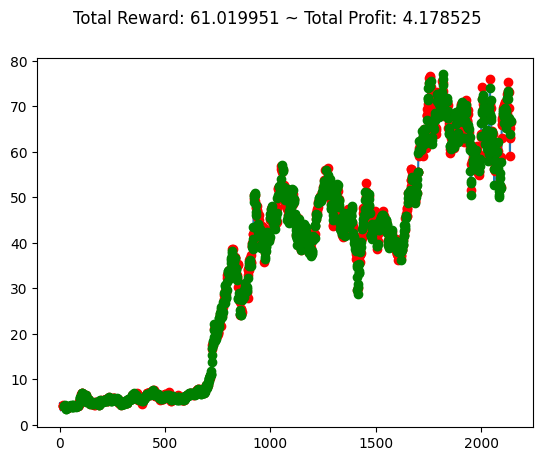

In [51]:
observation = env.reset(seed=2024)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

Create and training the model for 200 episodes or epochs

In [52]:
model = A2C("MlpPolicy", env, verbose=1)

# Create the callback: check every 2142 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=2142, log_dir=log_dir)

# Train the model
model.learn(total_timesteps=428400,callback=callback)

Streaming output truncated to the last 5000 lines.
|    n_updates          | 56999    |
|    policy_loss        | -0       |
|    value_loss         | 4.69e-07 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.13e+03  |
|    ep_rew_mean        | 19.4      |
| time/                 |           |
|    fps                | 443       |
|    iterations         | 57100     |
|    time_elapsed       | 643       |
|    total_timesteps    | 285500    |
| train/                |           |
|    entropy_loss       | -9.41e-06 |
|    explained_variance | -0.0316   |
|    learning_rate      | 0.0007    |
|    n_updates          | 57099     |
|    policy_loss        | 1.76e-10  |
|    value_loss         | 9.36e-08  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.13e+03 |
|    ep_rew_mean        | 19.4     |
| time/

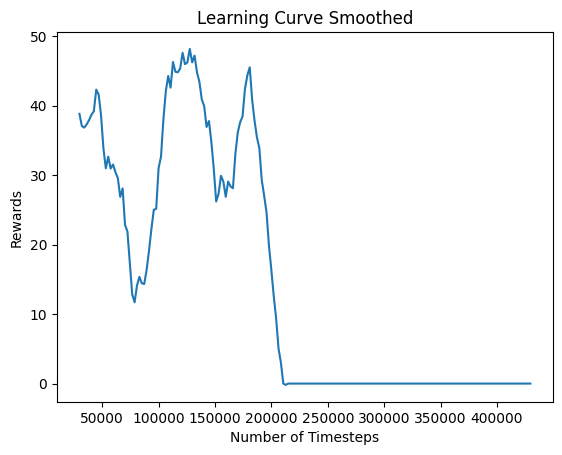

In [55]:
plot_results(log_dir)

### Evaluate the model for 5 repetitions

info: {'total_reward': 0.0, 'total_profit': 1000.0, 'position': <Positions.Short: 0>}


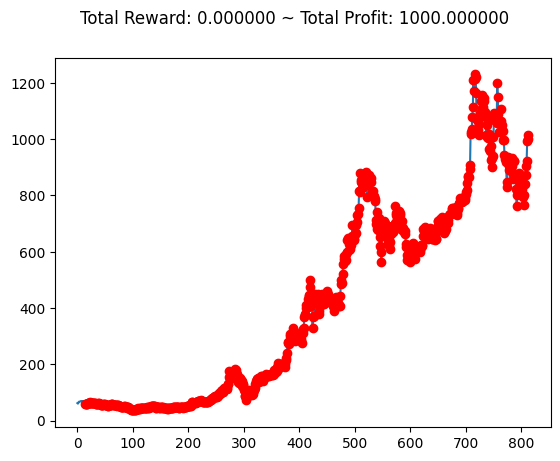

<ipython-input-56-fda5dd40a0a2>:27: RuntimeWarning: divide by zero encountered in scalar divide
  average_sharpe_ratio = np.mean(AWR) / np.std(AWR)


Sharpe Ratio: inf
info: {'total_reward': 0.0, 'total_profit': 1000.0, 'position': <Positions.Short: 0>}


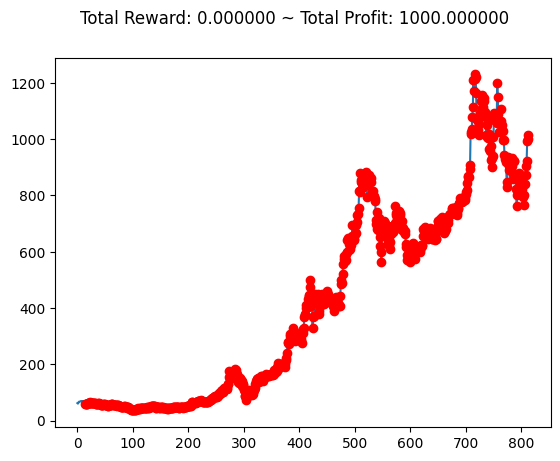

Sharpe Ratio: inf
info: {'total_reward': 0.0, 'total_profit': 1000.0, 'position': <Positions.Short: 0>}


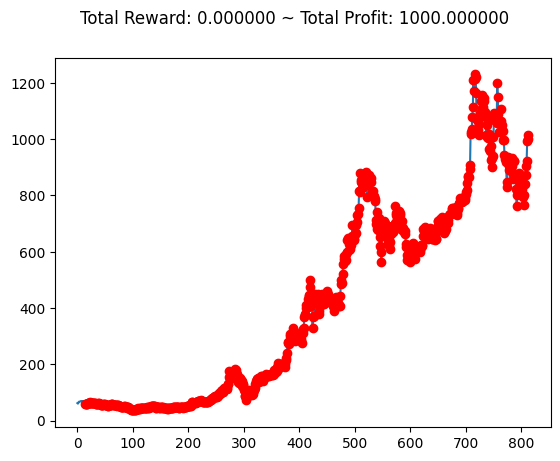

Sharpe Ratio: inf
info: {'total_reward': 0.0, 'total_profit': 1000.0, 'position': <Positions.Short: 0>}


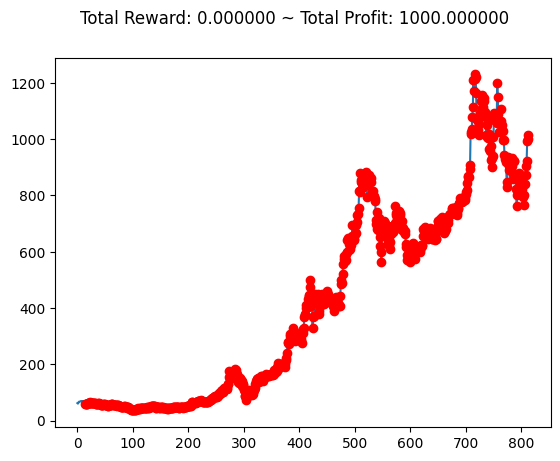

Sharpe Ratio: inf
info: {'total_reward': -0.022003173828125, 'total_profit': 984.796583266178, 'position': <Positions.Short: 0>}


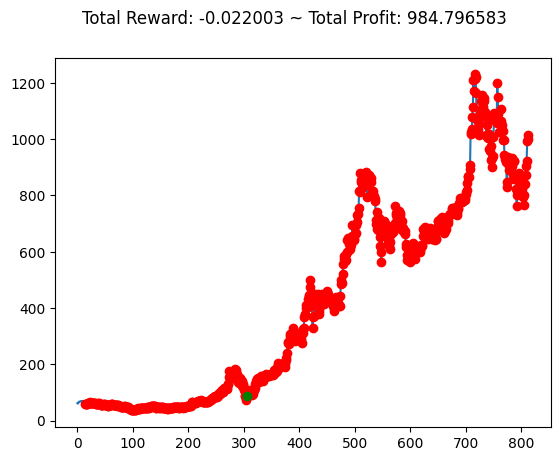

Sharpe Ratio: 135.36575426026803


In [56]:
total_profit_list = []
total_reward_list = []
total_sharpe_ratio_list = []

for i in range(5):

  env = MyCustomEnv(df=test_df, frame_bound=(WINDOW_SIZE, len(test_df)), window_size=WINDOW_SIZE)

  observation, info = env.reset(seed=2024)
  while True:
      action = model.predict(observation)
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      if done:
          print("info:", info)
          total_profit_list.append(info['total_profit'])
          total_reward_list.append(info['total_reward'])
          break

  plt.cla()
  env.unwrapped.render_all()
  plt.show()

  AWR = env.history['total_profit']

  average_sharpe_ratio = np.mean(AWR) / np.std(AWR)
  print('Sharpe Ratio:', average_sharpe_ratio)
  total_sharpe_ratio_list.append(average_sharpe_ratio)



In [57]:
print('average sharpe ratio: ',np.mean(total_sharpe_ratio_list))
print('average profit: ',np.mean(total_profit_list))

average sharpe ratio:  inf
average profit:  996.9593166532355
